In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix
from plotutil import PlotLayout

(-0.5, 19.5, 19.5, -0.5)

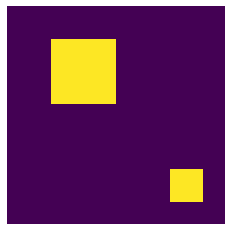

In [3]:
a = 20
x = np.zeros([a, a])
x[3:9, 4:10] = 1
x[15:18, 15:18] = 1
x0 = x.reshape(-1)
plt.imshow(x)
plt.axis("off")

## Constructing Laplacian

需要将 $20 \times 20$ 网格里的每个点全部摊开，得到一个 $400 \times 400$ 的拉普拉斯。

$$
L\phi_i=\lambda_i \phi_i
$$

(-0.5, 399.5, 399.5, -0.5)

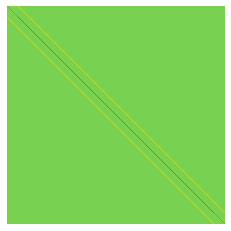

In [4]:
rows = []
cols = []
vals = []
for i in range(a):
    for j in range(a):
        rows.append(i * a + j)
        cols.append(i * a + j)
        if i in (0, a - 1) and j in (0, a - 1):
            # 顶点
            vals.append(-2)
        elif i in (0, a - 1) or j in (0, a - 1):
            # 边
            vals.append(-3)
        else:
            # 内部
            vals.append(-4)
        for dir in [(1, 0), (0, 1)]:
            i2 = i + dir[0]
            j2 = j + dir[1] 
            if i2 < a and j2 < a:
                rows.append(i * a + j);    cols.append(i2 * a + j2);   vals.append(1)
                rows.append(i2 * a + j2);  cols.append(i * a + j);     vals.append(1)

L = coo_matrix((vals, (rows, cols)), shape=[a ** 2, a ** 2], dtype=np.float64)

# eigval, eigvec = eigs(L, k=a ** 2 - 10)
L = L.toarray()
# 实对称矩阵的特征向量正交
# np.linalg.eig 可能由于数值原因，算出不正交的结果，要用 eigh 替代
eigval, eigvec = np.linalg.eigh(L)
plt.imshow(L)
plt.axis("off")

# Reconstructing initial state

检查一下特征分解是否成功，看看能不能恢复初始状态。

$$
f_0 = \sum_i \alpha_i \phi_i
$$

5.422311905034505e-14


(-0.5, 19.5, 19.5, -0.5)

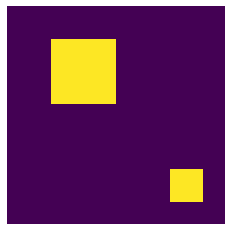

In [5]:
alpha0 = x0 @ eigvec # 400 @ 400 x 6
x1 = (alpha0 * eigvec).sum(-1)
print((x0 - x1).sum())
plt.imshow(np.abs(x1).reshape(a, a))
plt.axis("off")

## Solving the Heat Equation

Solving the PDE,

$$
\frac{\partial f(x, t)}{\partial t} = \frac{\partial^2 f(x, t)}{\partial x^2} \\
f(x, 0) = f_0(x)
$$

这里正负号的不同会对后面的 $\lambda$ 相关的正负号带来影响。

we get:

$$
f(x, t) = \sum_i \alpha_i \exp(\lambda_i t) \phi_i(x)
$$

allocating 2 rows x 3 cols for 6 subplots.
total heat at 0 is 45.00000000000015
total heat at 1 is 44.99999999999985
total heat at 2 is 44.99999999999975
total heat at 3 is 44.99999999999965
total heat at 4 is 44.99999999999955
total heat at 5 is 44.999999999999446


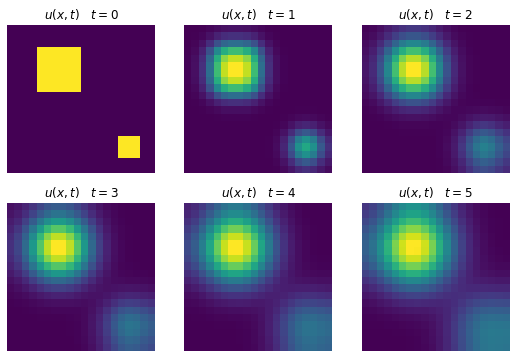

In [16]:
layout = PlotLayout(plt, 6, num_per_row=3, row_width=3, col_width=3)
layout.prepare()

for i in range(6):
    layout.subplot(i)
    xt = (alpha0 * np.exp(eigval * i * 1) * eigvec).sum(-1)
    xt = xt.reshape(a, a)
    plt.imshow(np.abs(xt))
    plt.axis("off")
    plt.title(f"$u(x,t)~~~t={i}$")
    print("total heat at", i, "is", np.abs(xt).sum())

## Caculating the Heat Kernel

Heat kernel $k_t(x, y)$ 指的是到第 t 个时刻为止，累积一共有多少热量从 $y$ 传到 $x$。

定义来自于：
$$
u(x, t) = \int k_t(x, y) u_0(y) dy
$$

解出来是：

$$
k_t(x, y) = \sum_i \exp (\lambda_i t) \phi_i(x) \phi_i(y)
$$

注意这里的 $x$、$y$ 不是横坐标纵坐标，而是代表区域内的两个点。为了方便，在此我们只取某个固定的 $y$ 来看该点对其他区域（所有 $x$ ）的影响。

allocating 2 rows x 3 cols for 6 subplots.


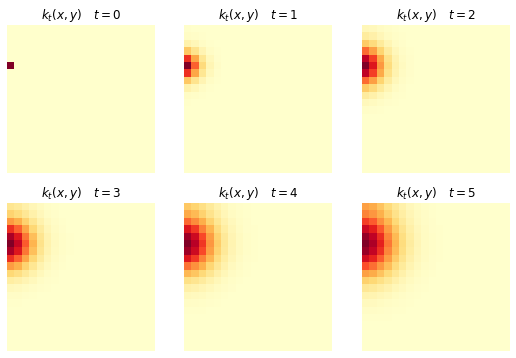

In [15]:
layout = PlotLayout(plt, 6, num_per_row=3, row_width=3, col_width=3)
layout.prepare()

y = (4, 20)
y = y[0] * a + y[1]
for i in range(6):
    layout.subplot(i)
    # 每一列是一个特征向量
    kernel = (
        np.exp(eigval * i * 1).reshape(1, a ** 2)  # (1, D)
        * eigvec   # (D, D)
        * eigvec[y: y+1, :]   # (1, D) 
    ).sum(1)
    plt.imshow(np.abs(kernel).reshape(a, a), cmap="YlOrRd")
    plt.title(f"$k_t(x,y)~~~t={i}$")
    plt.axis("off")